In [70]:
import os
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy.wcs import WCS
from astropy.table import Table
import matplotlib.pyplot as pl
import matplotlib.colors as mc
from scipy.interpolate import NearestNDInterpolator
from scipy.optimize import curve_fit 
import scipy.integrate as integrate
import scipy.special as special
from scipy import stats
from numpy import linspace, array, logspace, sin, cos, pi, arange, sqrt, arctan2, arccos
from mpl_toolkits.mplot3d import Axes3D
import emcee

from initial_guess_ellipse import *






from collections import OrderedDict


In [2]:
tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/synth_table.tex")
absorp_tab = Table.read('/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/3d_cmz_pIII_tab2.csv')
starcount_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/starcounts_tab.tex")

xray_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/xray_methods.tex")
nogueras_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/nogueras_measures.tex")


cat_index = tab['leaf_id']
cloud_name = tab['cloud_name']
corr_coeff = tab['corr_coeff']
flux_diff = tab['flux_diff']
fdiff_stdv = tab['flux_diff_stdv']
flux_ratio = tab['flux_ratio']
fratio_stdv = tab['flux_ratio_stdv']
absorp_value = tab['absorp_value']
absorp_sigma = tab['absorp_sigma']
starcount_ratio = list(starcount_tab['counts_ratio_from_avg'].copy())
starcount_ratio_stdv = list(starcount_tab['counts_ratio_stdv'].copy())
nogueras_value = nogueras_tab['LOS_dist_pc']
nogueras_sigma = nogueras_tab['sigma_pc']



tab
  

leaf_id,cloud_name,l,b,v,sigma,rad,mass_msun,corr_coeff,flux_diff,flux_diff_stdv,flux_ratio,flux_ratio_stdv,absorp_value,absorp_sigma,NF_decision,absorp_NF,lb_pixel_mask
str3,str14,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,str3,int64
1,G359.475-0.044,-0.525,-0.044,-102,6,4.3,60000.0,0.26,-20.97,59.09,0.37,0.2,nan,nan,LN,nan,1
2,G359.508-0.135,-0.492,-0.135,-56,9,8.7,290000.0,0.38,-73.25,56.22,0.46,0.19,nan,nan,N,nan,1
3,G359.561-0.001,-0.439,-0.001,-90,8,2.7,21000.0,0.22,-59.31,23.73,0.38,0.09,2.15,0.06,U,F,1
4a,G359.595-0.223,-0.405,-0.223,-27,13,4.6,81000.0,0.43,-79.52,73.95,0.37,0.3,nan,nan,N,nan,1
4b,G359.595-0.223,-0.405,-0.223,-20,8,4.6,81000.0,0.26,-78.19,101.97,0.36,0.42,nan,nan,LN,nan,0
5,G359.608+0.018,-0.392,0.018,-78,5,2.0,12000.0,0.18,-79.45,23.27,0.38,0.11,0.52,0.07,LN,N,1
6a,G359.688-0.132,-0.312,-0.132,-29,5,5.6,87000.0,0.62,-52.41,25.94,0.4,0.1,3.3,0.11,LN,F,0
6b,G359.688-0.132,-0.312,-0.132,-21,12,5.6,87000.0,0.28,-61.84,29.84,0.41,0.09,2.28,0.05,U,F,1
7a,G359.701+0.032,-0.299,0.032,-73,11,2.4,14000.0,-0.54,-96.86,32.34,0.46,0.12,0.36,0.05,LN,N,1


In [3]:
### Create table of all raw metrics used to build PPDFs ###

PPDF_meth_tab = Table()

PPDF_meth_tab['leaf id'] = tab['leaf_id']
PPDF_meth_tab['cloud name'] = tab['cloud_name']
PPDF_meth_tab['l'] = tab['l'] * u.degree
PPDF_meth_tab['b'] = tab['b'] * u.degree
PPDF_meth_tab['v'] = tab['v'] * u.km/ u.s
PPDF_meth_tab['flux diff'] = tab['flux_diff'] * u.MJy/u.sr
PPDF_meth_tab['flux diff stdv'] = tab['flux_diff_stdv'] * u.MJy/u.sr
PPDF_meth_tab['flux ratio'] = tab['flux_ratio']
PPDF_meth_tab['flux ratio stdv'] = tab['flux_ratio_stdv']
PPDF_meth_tab['corr coeff'] = tab['corr_coeff']
PPDF_meth_tab['absorption fraction'] = tab['absorp_value']
PPDF_meth_tab[r'absorption fraction $\sigma$ '] = tab['absorp_sigma']
PPDF_meth_tab['star count ratio'] = list(starcount_tab['counts_ratio_from_avg'].copy().round(3))
PPDF_meth_tab['star count ratio stdv'] = list(starcount_tab['counts_ratio_stdv'].copy().round(3))


PPDF_meth_tab.write("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/paper_items/Tables/PPDF_method_info.tex", format = 'latex', overwrite=True)



In [4]:
PPDF_meth_tab

leaf id,cloud name,l,b,v,flux diff,flux diff stdv,flux ratio,flux ratio stdv,corr coeff,absorption fraction,absorption fraction $\sigma$,star count ratio,star count ratio stdv
,,deg,deg,km / s,MJy / sr,MJy / sr,,,,,,,
str3,str14,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,G359.475-0.044,-0.525,-0.044,-102.0,-20.97,59.09,0.37,0.2,0.26,nan,nan,0.656,0.185
2,G359.508-0.135,-0.492,-0.135,-56.0,-73.25,56.22,0.46,0.19,0.38,nan,nan,0.844,0.145
3,G359.561-0.001,-0.439,-0.001,-90.0,-59.31,23.73,0.38,0.09,0.22,2.15,0.06,0.708,0.125
4a,G359.595-0.223,-0.405,-0.223,-27.0,-79.52,73.95,0.37,0.3,0.43,nan,nan,0.536,0.219
4b,G359.595-0.223,-0.405,-0.223,-20.0,-78.19,101.97,0.36,0.42,0.26,nan,nan,0.498,0.235
5,G359.608+0.018,-0.392,0.018,-78.0,-79.45,23.27,0.38,0.11,0.18,0.52,0.07,0.962,0.094
6a,G359.688-0.132,-0.312,-0.132,-29.0,-52.41,25.94,0.4,0.1,0.62,3.3,0.11,0.977,0.139
6b,G359.688-0.132,-0.312,-0.132,-21.0,-61.84,29.84,0.41,0.09,0.28,2.28,0.05,1.041,0.092


In [5]:
def z_norming(i, min_value, max_value):
    z_i = 2. * ((i - min_value) / (max_value - min_value)) - 1.
    return z_i

def stdv_z_norming(i, min_value, max_value):
    width = abs(max_value - min_value)
    z_i =  ((i - min_value) / (max_value - min_value)) 
    return abs(z_i)

# normalize the data value between -1 and 1 for the 
# flux difference list 
# but need to center it on -108
fdiff_cn = z_norming(-108, -150, 150)

fdiff_stdv_centered = fdiff_stdv 

# flux ratio is centered on 0.5
fratio_cn = z_norming(0.5, 0., 1.)
fratio_stdv_centered = (fratio_stdv)

# Absorption centered on 1.
#absorp_cn = z_norming(1., np.nanmin(absorp_value), 3.5)
absorp_cn = z_norming(1., 0, 2)


# Star Count ratio centered on 1, min 0 and max 2
countratio_cn = z_norming(1., 0, 2)


flux_ratio_normed = []
flux_diff_normed = []
fdiff_stdv_normed = []
fratio_stdv_normed = []
absorp_normed = []
absorp_stdv_normed = []
starcounts_normed = []
starcounts_stdv_normed = []
counts_ratio_stdv_calc = []

for i in range(len(cat_index)):
    
    ###FDIFF NORMING 
    z_fdiff_i = z_norming(flux_diff[i], -150, 150)
    flux_diff_normed.append(z_fdiff_i-fdiff_cn) 
    
    z_fdiff_stdv_i = stdv_z_norming(fdiff_stdv_centered[i],-150,150)
    fdiff_stdv_normed.append(z_fdiff_stdv_i)
    
    ###FRATIO NORMING 
    z_i = z_norming(flux_ratio[i], 0, 1)
    flux_ratio_normed.append(-(z_i-fratio_cn)) 
    
    #z_fratio_stdv_i = z_norming(fratio_stdv_centered[i], np.nanmin(flux_ratio), np.nanmax(flux_ratio))
    z_fratio_stdv_i = stdv_z_norming(fratio_stdv_centered[i], 0, 1)
    fratio_stdv_normed.append(np.abs((z_fratio_stdv_i)))
    
    ###ABSORP NORMING 
    if np.isnan(absorp_value[i]) == False:
        if absorp_value[i]<34:
            if cat_index[i] == '25' or cat_index[i] == '9': #manually exclude SgrB2 and 20 kms Cloud.
                absorp_normed.append(np.nan)
                absorp_stdv_normed.append(np.nan)
            else: 
                #z_i_absorp = z_norming(absorp_value[i], np.nanmin(absorp_value), 3.5)
                z_i_absorp = z_norming(absorp_value[i], 0,2)
                absorp_normed.append(float(-(z_i_absorp-absorp_cn)))

                z_i_absorp_stdv = stdv_z_norming(absorp_sigma[i],0,1)
                absorp_stdv_normed.append(float(z_i_absorp_stdv))
            
        if absorp_value[i]>34: #ID 8b has an extremely large absoprtion frac. Should be ignored.
            absorp_normed.append(np.nan)
            absorp_stdv_normed.append(np.nan)

    if np.isnan(absorp_value[i]) == True:
        absorp_normed.append(np.nan)
        absorp_stdv_normed.append(np.nan)
        
    ###STARCOUNTS NORMING
    z_countratio_i = z_norming(starcount_ratio[i], 0, 2)
    starcounts_normed.append(-(z_countratio_i-countratio_cn) )
    
    #z_countratio_stdv_i =  stdv_z_norming(starcount_stdv_filter[i], np.nanmin(starcount_stdv_filter), np.nanmax(starcount_stdv_filter))
    
    z_countratio_stdv_i =  stdv_z_norming(starcount_ratio_stdv[i], 0,2)
    counts_ratio_stdv_calc.append(z_countratio_stdv_i)
    
starcounts_stdv_normed = np.full(len(counts_ratio_stdv_calc), 3*np.nanmax(counts_ratio_stdv_calc))
#starcounts_stdv_normed = 3* counts_ratio_stdv_calc
#fratio_stdv_normed = np.full(len(fratio_stdv_normed),np.nanmean(fratio_stdv_normed)) #flux ratio is also fairly susceptible to uncertainty in the central region





In [81]:
#This dist used for flux ratio, flux diff, and starcount methods
def gauss_dist(x, mu, sigma):
    sigma=abs(sigma)
    #factor = 1./( sigma * np.sqrt(2.*np.pi))
    exp = np.exp(- (x - mu)**2 / (2.* (sigma**2 )))
    return    exp 



def corr_coeff_gauss_dist(x, mu):
    if np.isnan(mu)==True:
        return x*np.nan

    if (mu < 0) or (mu > 0.3):
        sigma = np.nanstd(corr_coeff)
    if (mu < 0.3) & (mu >= -0.3):
        sigma = np.nanstd(3.*corr_coeff)
    
    #factor = 1./( sigma * np.sqrt(2*np.pi))
    exp = np.exp(- (x - mu)**2 / (2.* (sigma**2 )))
        
    return   exp 



def absorp_gauss_dist(x, mu, sigma):
    #sigma = 0.3*mu #sigma is 30% of the peak value
    #sigma = np.nanstd(absorp_normed, where=np.array(absorp_value)<3.5)
    #factor = 1./( sigma * np.sqrt(2*np.pi))
    exp = np.exp(- (x - mu)**2 / (2.* (sigma**2 )))
        
    return     exp 



#xray methods use step function
def hat(x,fdist, ndist):
    y=np.zeros(np.shape(x))
    
    # need to normalize so area under the curve is unity
    width = abs(fdist - ndist)
    h = 1./width
    y[(x<ndist) & (x>fdist)]+=h
    y[(x>=ndist)|(x<=fdist)]=0
    
     
    return y



#For creating a posterior gaussian after the fittings
def gaussian(x, A, mu, sigma):
    return A * np.exp(- (x - mu)**2 / (2.* (sigma**2 )))



In [82]:
### XRAY METHODS ###
# Xray methods give results in pc in front/behind
# Use the initial guess of an ellipse to convert to (-1,1) N/F scale?
# top-down y radius 

#############################
# define initial guess ring
#############################

a_rings = 0.09 # x axis of the rings in kpc
b_rings = 0.055 # y axis of the rings in kpc
z_rings = 0.0125 # height of the ring above/below plane in kpc
v_rings = 130.0 # tangential velocity at initial point
theta_rings = np.radians(25) # inclination of the rings
dphi = np.radians(1)
phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)
initial_rings = Ring(phi,a_rings,b_rings,z_rings,v_rings,theta_rings,xyzsun,vxyzsun)


# convert initial ellipse y limits to (-1,1)
ring_F_y, ring_N_y = np.nanmin(initial_rings.y), np.nanmax(initial_rings.y)
ring_F_y, ring_N_y =-.150,.150


In [170]:
x = np.arange(-5,5, 0.01)
    
def weights(self_dict, key):
    
    
    num_keys = len(self_dict.items())-1
    w_list = []
    
    for i in self_dict.items():
        if i[0] == 'corr_coeff': 
            ww_corr = 2.
            w_list.append(ww_corr)
        if i[0] == 'absorp': 
            ww_absorp = 2.
            w_list.append(ww_absorp)
        if i[0] == 'fratio': 
            ww_fratio = 1.
            w_list.append(ww_fratio)
        if i[0] == 'fdiff': 
            ww_fdiff = 1.
            w_list.append(ww_fdiff)
        if i[0] == 'starcount': 
            ww_starcounts = 1.
            w_list.append(ww_starcounts)
        if i[0] == 'nogueras': 
            ww_nogueras = 2.
            w_list.append(ww_nogueras)
        if i[0] == 'xray':  
            ww_xray = 2.
            w_list.append(ww_xray)
        
    total_w = np.sum(w_list)
    
    if key == 'corr_coeff':  return ww_corr        /total_w
    if key == 'absorp':      return ww_absorp      /total_w
    if key == 'fratio':      return ww_fratio      /total_w
    if key == 'fdiff':       return ww_fdiff       /total_w
    if key == 'starcount':   return ww_starcounts  /total_w
    if key == 'nogueras':    return ww_nogueras    /total_w
    if key == 'xray':        return ww_xray        /total_w
    if key == 'posterior':   return 1.
    
    

class ppdf:
        
    def __init__(self, cloud_id):

        x = np.arange(-5,5, 0.01)

        cat_id = np.where(cat_index == cloud_id)[0][0]

        if np.isnan(corr_coeff[cat_id])==False:
            r_dist = corr_coeff_gauss_dist(x, corr_coeff[cat_id]) 
            r_norm = integrate.quad(corr_coeff_gauss_dist, -np.inf, np.inf, args=(corr_coeff[cat_id]))[0]
            r_dist      /=  r_norm 
            self.corr_coeff = r_dist 
            

        if np.isnan(absorp_normed[cat_id])==False:
            #absorp_dist = absorp_gauss_dist(x, absorp_normed[cat_id])
            absorp_dist = gauss_dist(x, absorp_normed[cat_id],3*absorp_stdv_normed[cat_id])
            absorp_norm = integrate.quad(gauss_dist, -np.inf, np.inf, args=(absorp_normed[cat_id], 3*absorp_stdv_normed[cat_id]))[0]
            #absorp_norm = integrate.quad(absorp_gauss_dist, -np.inf, np.inf, args=(absorp_normed[cat_id]))[0]
            absorp_dist /=  absorp_norm
            self.absorp = absorp_dist 

        if np.isnan(flux_ratio_normed[cat_id])==False:
            fratio_dist = gauss_dist(x, flux_ratio_normed[cat_id],fratio_stdv_normed[cat_id])
            
            fratio_norm = integrate.quad(gauss_dist, -np.inf, np.inf, args=(flux_ratio_normed[cat_id],fratio_stdv_normed[cat_id]))[0]
            fratio_dist /=  fratio_norm 
            self.fratio = fratio_dist

        if np.isnan(flux_diff_normed[cat_id])==False:
            fdiff_dist = gauss_dist(x, flux_diff_normed[cat_id],fdiff_stdv_normed[cat_id] )    
            fdiff_norm = integrate.quad(gauss_dist, -np.inf,np.inf, args=(flux_diff_normed[cat_id],fdiff_stdv_normed[cat_id]))[0]
            fdiff_dist  /=  fdiff_norm
            self.fdiff = fdiff_dist

        if np.isnan(starcounts_normed[cat_id])==False:
            starcount_dist = gauss_dist(x, starcounts_normed[cat_id],starcounts_stdv_normed[cat_id] )    
            starcount_norm = integrate.quad(gauss_dist, -np.inf,np.inf, args=(starcounts_normed[cat_id],starcounts_stdv_normed[cat_id]))[0]
            starcount_dist  /=  starcount_norm
            self.starcount = starcount_dist
            
        #xray method for relevant clouds (modeled by tophat)
        if (cloud_id =='13') | (cloud_id =='14') :
            cloud_n = (xray_tab['xray_NEAR_los_dist_pc'][np.where(xray_tab['cloud_index']==int(cloud_id))][0])/1e3
            cloud_f = (xray_tab['xray_FAR_los_dist_pc'][np.where(xray_tab['cloud_index']==int(cloud_id))][0])/1e3
            print('xray', cloud_n, cloud_f)
            xray_hat_n, xray_hat_f = z_norming(cloud_n, ring_F_y, ring_N_y), z_norming(cloud_f, ring_F_y, ring_N_y)
            self.xray = hat(x,xray_hat_f, xray_hat_n)

        #nogueras LOS measures for 20 and 50 kms Clouds
        if (cloud_id =='9') | (cloud_id =='10') :
            nog_dist_kpc = (nogueras_value[np.where(nogueras_tab['cloud_index']==int(cloud_id))][0])/1e3
            nog_sig_kpc = (nogueras_sigma[np.where(nogueras_tab['cloud_index']==int(cloud_id))][0])/1e3
            nog_dist_normed = z_norming(nog_dist_kpc, ring_F_y, ring_N_y)
            nog_sig_normed  = stdv_z_norming(nog_sig_kpc, 0, ring_N_y)
            nog_dist = gauss_dist(x, nog_dist_normed,nog_sig_normed)  
            nog_norm = integrate.quad(gauss_dist, -np.inf,np.inf, args=(nog_dist_normed, nog_sig_normed))[0]
            nog_dist /= nog_norm
            self.nogueras = nog_dist


        ### Calculate the posterior PDF
        
        total_pdf = np.full(np.shape(x), None, dtype=object) 
        #total_pdf[:] = None
        
        self_dict = vars(self)
        
        uniform_pdf = np.ones(np.shape(x))
        
        ### Assign weights to the distributions
        ### Gaussians are best weighted by the means 
        ### other PDF shapes may be better weighted by amplitude
        for i in self_dict.items():
            #total_pdf *= i[1]
        
            
            if i[0]=='corr_coeff'  :     
                w = weights(self_dict,i[0])
                i_weighted = (i[1]*(1+w) + uniform_pdf*(w) )/ np.sum(i[1])
            if i[0]=='absorp'      :     
                w = weights(self_dict,i[0])
                i_weighted = (i[1]*(1+w) + uniform_pdf*(w) )/ np.sum(i[1])
            if i[0]=='fratio'      :     
                w = weights(self_dict,i[0])
                i_weighted = (i[1]*(1+w) + uniform_pdf*(w) )/ np.sum(i[1])
            if i[0]=='fdiff'       :     
                w = weights(self_dict,i[0])
                i_weighted = (i[1]*(1+w) + uniform_pdf*(w) )/ np.sum(i[1])
            if i[0]=='starcount'   :     
                w = weights(self_dict,i[0])
                i_weighted = (i[1]*(1+w) + uniform_pdf*(w) )/ np.sum(i[1])
            if i[0]=='nogueras'        :  
                w = weights(self_dict,i[0])
                i_weighted = (i[1]*(1+w) + uniform_pdf*(w) )/ np.sum(i[1])     
            if i[0]=='xray'        :  
                w = weights(self_dict,i[0])
                i_weighted = i[1]*(1+w) / np.sum(i[1])
       
            if total_pdf[0] == None:
                total_pdf = i_weighted
            else:
                total_pdf  *= i_weighted
            total_norm  = integrate.trapezoid(total_pdf, x)
            total_pdf  /= total_norm
            #total_pdf/=total_pdf.max()
        
        self.posterior = total_pdf


        
        
        if cloud_id == '16a': 
            self.posterior = np.empty(np.size(total_pdf))
            self.posterior[:] = np.nan 
        

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf',
                   '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']               
        

def plotting_color_label(key):
    if key == 'corr_coeff': return '#377eb8'
    if key == 'absorp': return '#e41a1c'
    if key == 'fratio': return '#4daf4a'
    if key == 'fdiff': return '#ff7f00'
    if key == 'starcount': return '#dede00'
    if key == 'xray': return '#f781bf'
    if key == 'nogueras': return '#a65628'
    if key == 'posterior': return 'black'
    if key == 'MCMC posterior': return 'gray'

def plotting_linestyles(key):
    if key == 'corr_coeff': return '--'
    if key == 'absorp': return '-'
    if key == 'fratio': return '-.'
    if key == 'fdiff': return '--'
    if key == 'starcount': return '--'
    if key == 'xray': return '-'
    if key == 'nogueras': return '-'
    if key == 'posterior': return '-'
    if key == 'MCMC posterior': return '-'
    


In [171]:
def plot_pdf(cloud_id, pdfvar):
    
    pdfvec = vars(pdfvar)
    cat_id = np.where(cat_index == cloud_id)[0][0]

    if ~np.isnan(pdfvar.posterior).any() == True:
        parameters, covariance =curve_fit(gaussian, x, pdfvar.posterior, 
                                        p0 = [1, x[np.where(pdfvar.posterior==np.max(pdfvar.posterior))][0],
                                                np.std(pdfvar.posterior)])

    peak_val = pdfvar.posterior.max()
    peak_mu = (x[np.where(pdfvar.posterior == pdfvar.posterior.max())[0]])
    confidence_interval = stats.norm.interval(0.95, loc=peak_mu, scale=stats.sem(pdfvar.posterior))
    CI_sig = abs(confidence_interval[1] -confidence_interval[0])



    ###Plot the stuff 
    fig, ax = plt.subplots(1, 1)
    for i in pdfvec.items():
        ax.plot(x, i[1], label = '{}'.format(i[0]), linestyle=plotting_linestyles(i[0]), color=plotting_color_label(i[0]) )


    ax.set_xlabel('Near vs Far Distinction', fontsize= 13, labelpad=30)
    ax.set_ylabel('Relative Probability',fontsize= 13)

    ax.grid(axis='y')
    

    #ax.set_ylim(0,1.1)
    ax.set_xlim(-1,1)
    

    if ~np.isnan(peak_val)==True:
        ax.set_ylim(0, peak_val+1)
        ax.vlines(parameters[1], 0, parameters[0]+1, color ='grey', linestyle='-.', label = r'$\mu$'+'$= {:.2f}$'.format(parameters[1]))
    ax.text(.95, .95, 'ID: {}'.format(cat_index[cat_id]), fontsize=13, ha='right', va='top', 
            transform=ax.transAxes)

    ax.text(-0.01, -.08, 'FAR', fontsize=13, ha='left', va='top', 
            transform=ax.transAxes)
    ax.text(0.915, -.08, 'NEAR', fontsize=13, ha='left', va='top', 
            transform=ax.transAxes)

    ax.legend(loc=2)
    
    plt.show()
        
    return

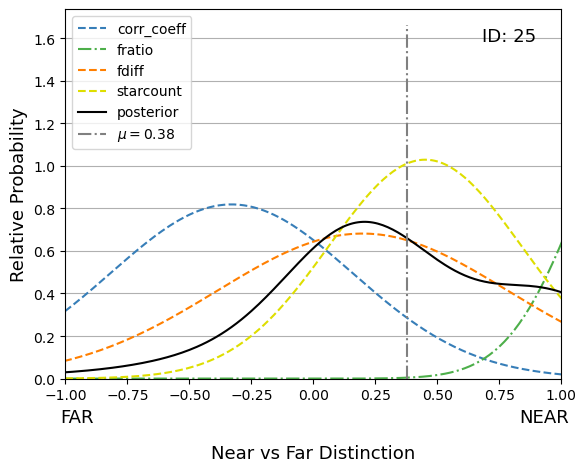

In [214]:
cloudd = '25'
pdfvec=ppdf(cloudd)
plot_pdf(cloudd,pdfvec)

In [66]:
from scipy.stats import norm
i = 0.829
norm.cdf(i, loc=mcmc_pdfvec.curve_fit_params[1], scale=abs(mcmc_pdfvec.curve_fit_params[2]) )- 0.5, 0.5 - norm.cdf(i, loc=mcmc_pdfvec.curve_fit_params[1], scale=abs(mcmc_pdfvec.curve_fit_params[2]) )

(np.float64(-0.0009764034337573779), np.float64(0.0009764034337573779))

In [ ]:
area_between = abs(0.5 - norm.cdf(common_nf, loc=post_mu[i], scale=abs(post_sigma[i]) ))

In [44]:
mcmc_pdfvec.curve_fit_params #A, mu , sig

array([8.48131353, 0.82911337, 0.04632171])

In [68]:
print(pdfvec.absorp)
print(pdfvec.fratio)
print(pdfvec.fdiff)
print(max(pdfvec.posterior))

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1.66969062e-212 2.64258886e-212 4.18147185e-212 ... 2.52774399e-166
 1.68404177e-166 1.12170491e-166]
8.416845237543846


In [69]:
vars(pdfvec)

{'corr_coeff': array([0., 0., 0., ..., 0., 0., 0.], shape=(4000,)),
 'absorp': array([0., 0., 0., ..., 0., 0., 0.], shape=(4000,)),
 'fratio': array([0., 0., 0., ..., 0., 0., 0.], shape=(4000,)),
 'fdiff': array([1.66969062e-212, 2.64258886e-212, 4.18147185e-212, ...,
        2.52774399e-166, 1.68404177e-166, 1.12170491e-166], shape=(4000,)),
 'starcount': array([0., 0., 0., ..., 0., 0., 0.], shape=(4000,)),
 'posterior': array([6.93440525e-05, 6.93440525e-05, 6.93440525e-05, ...,
        6.93440525e-05, 6.93440525e-05, 6.93440525e-05], shape=(4000,))}

# Run routine for entire catalog and create a table with the PPDF posterior parameters & MC posterior parameters

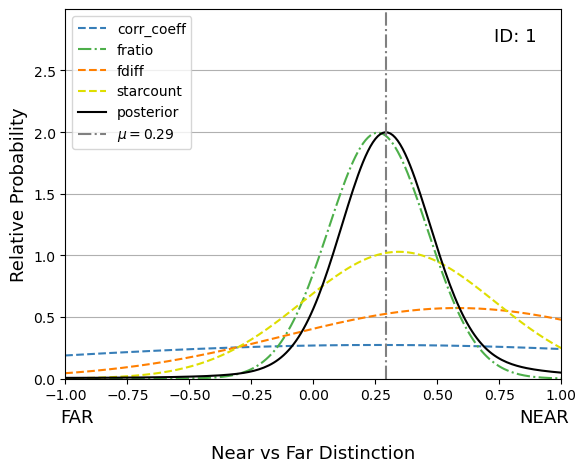

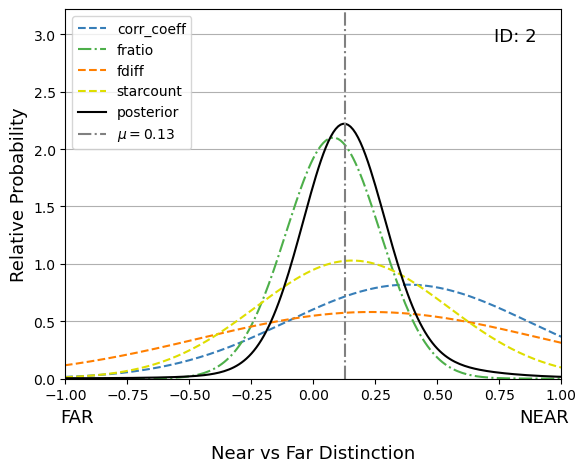

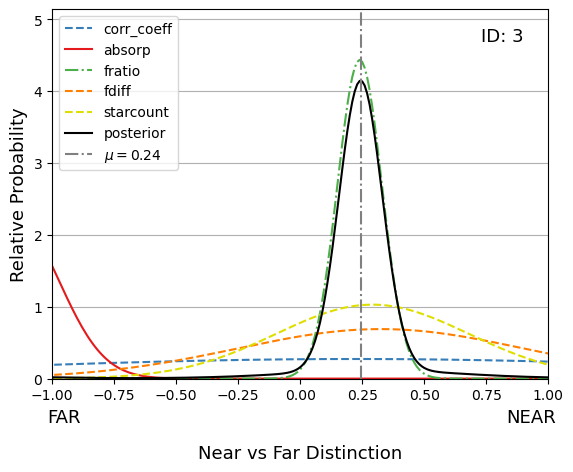

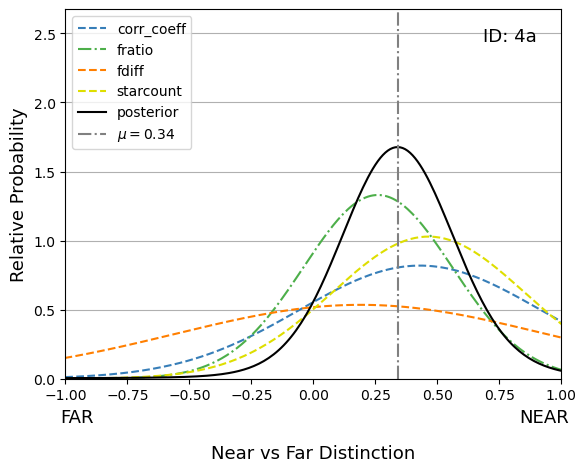

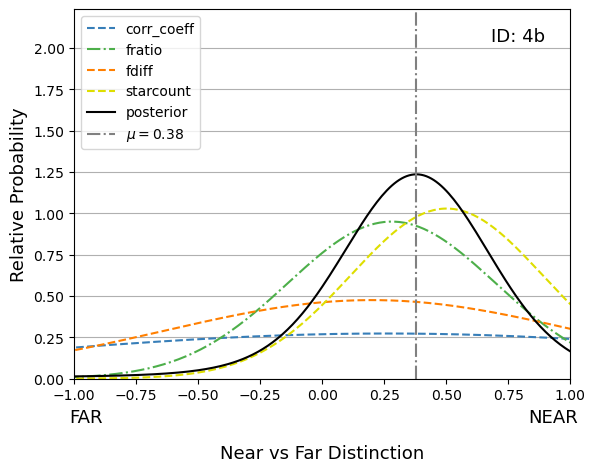

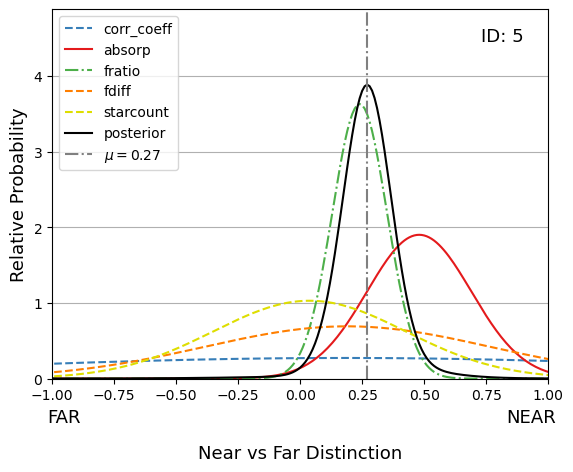

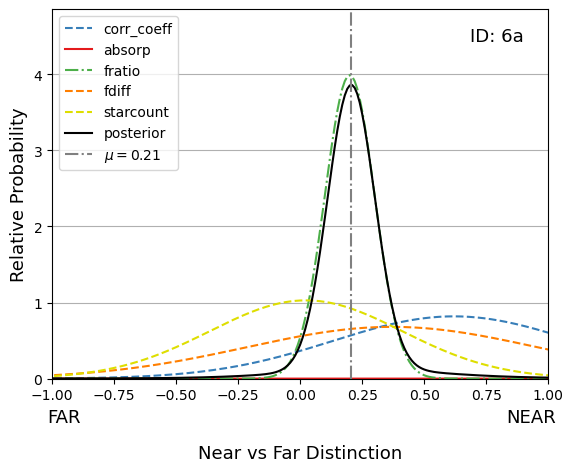

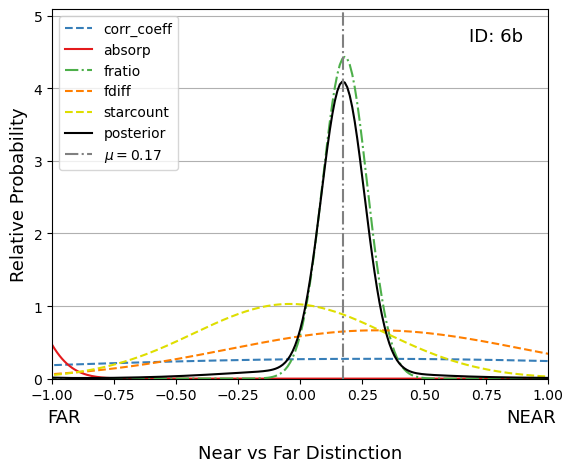

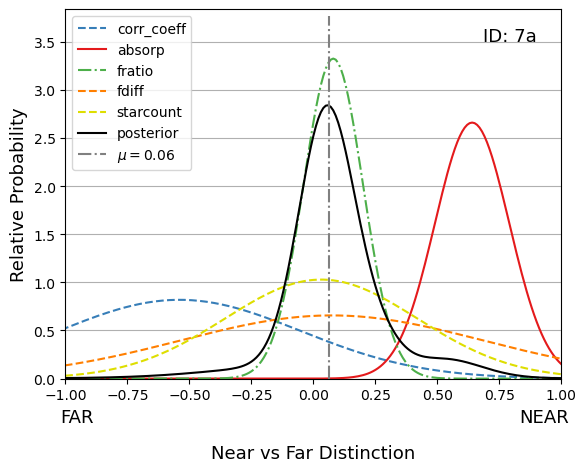

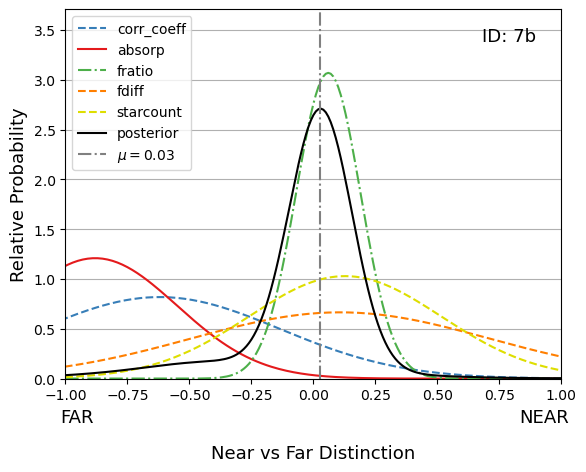

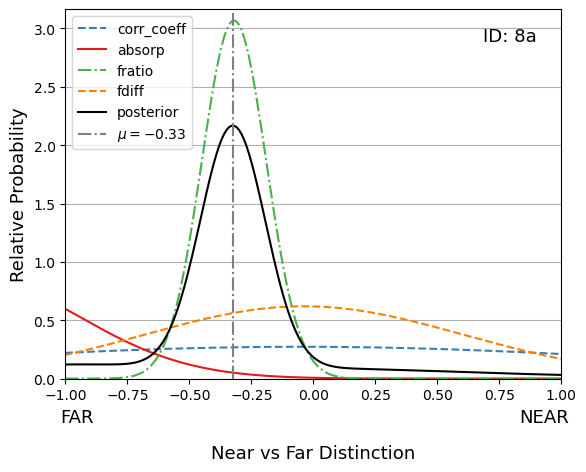

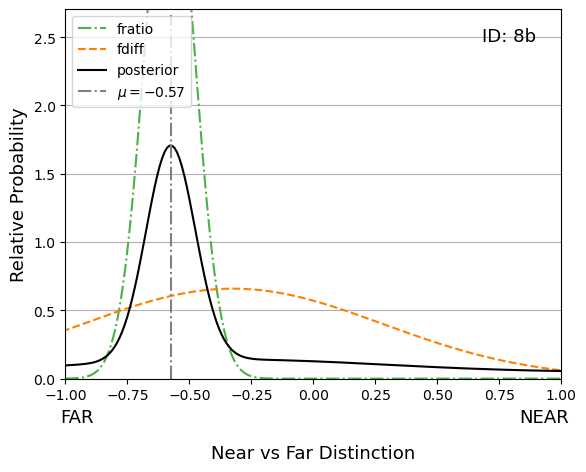

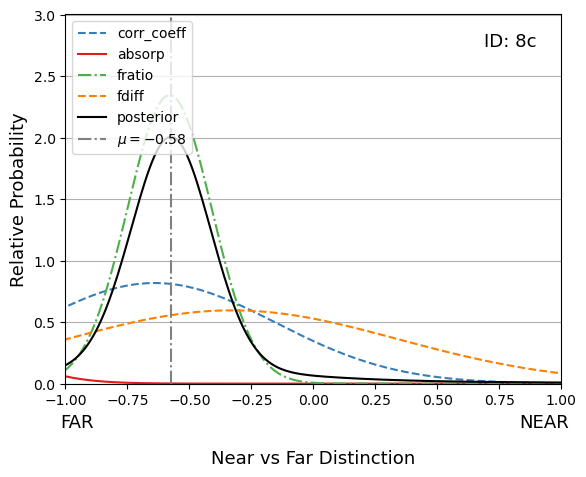

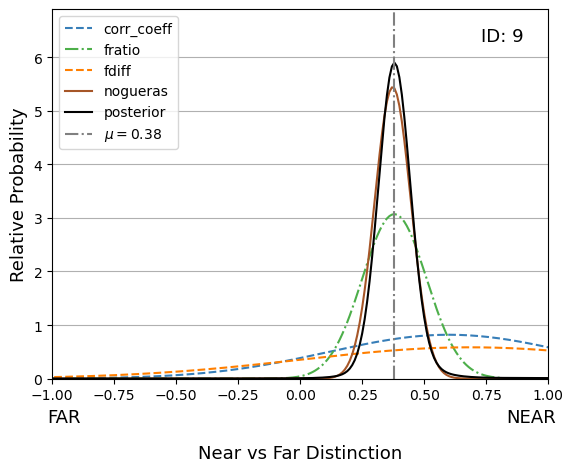

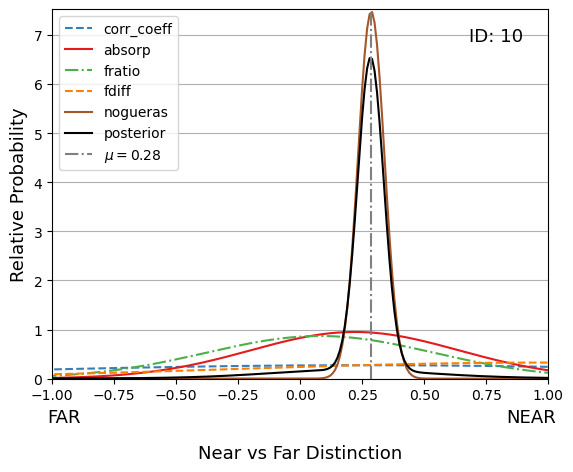

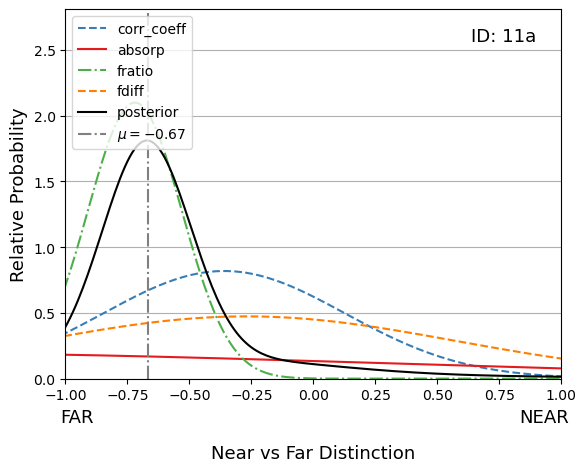

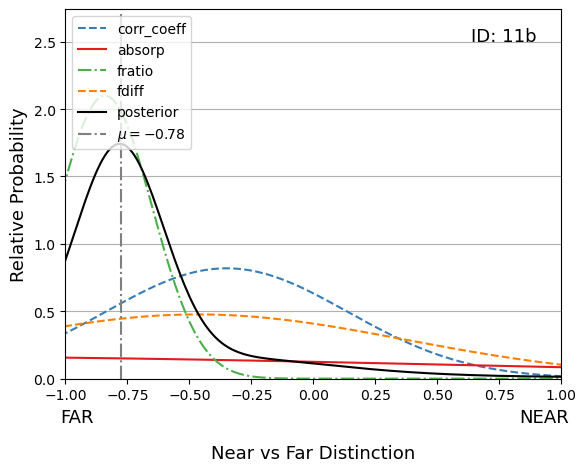

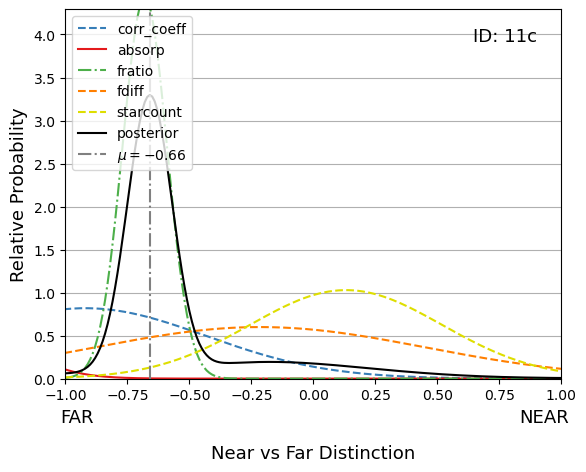

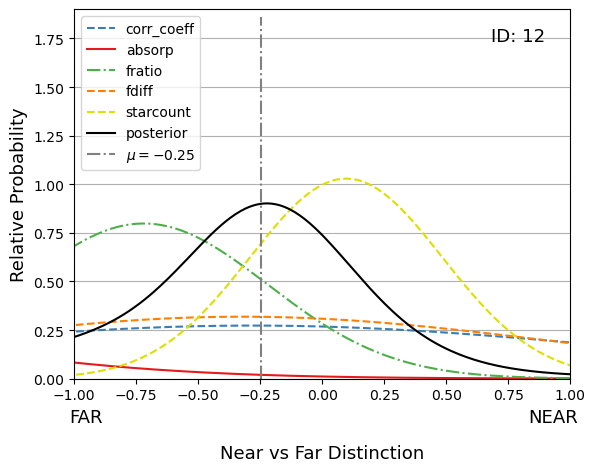

xray 0.01 -0.03


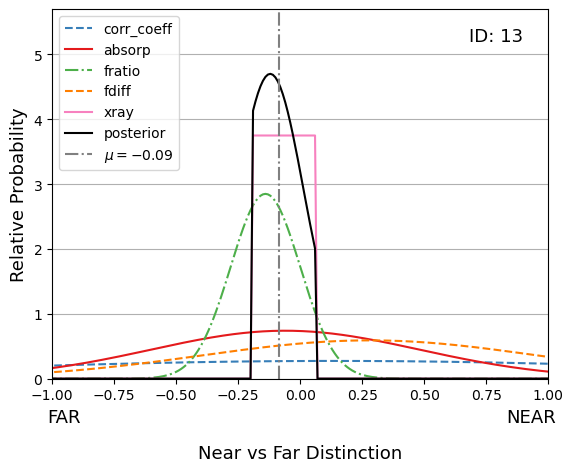

xray 0.02 -0.03


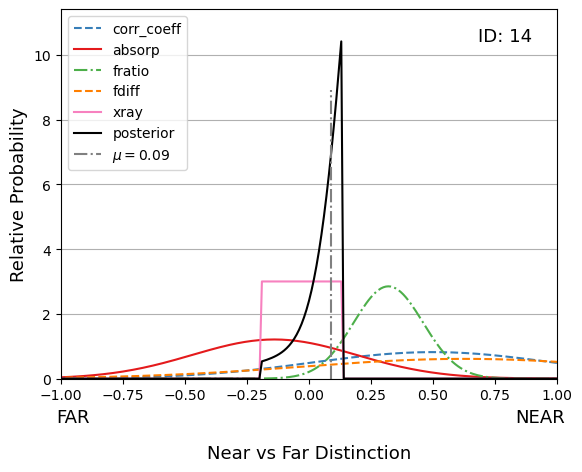

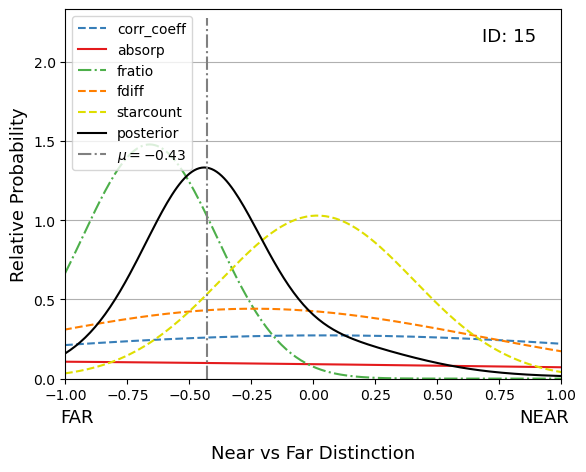

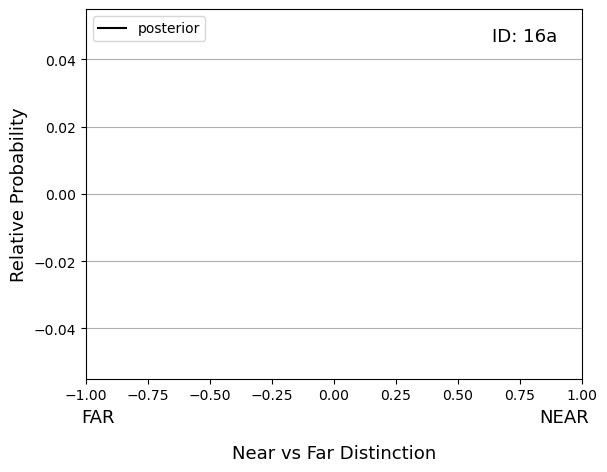

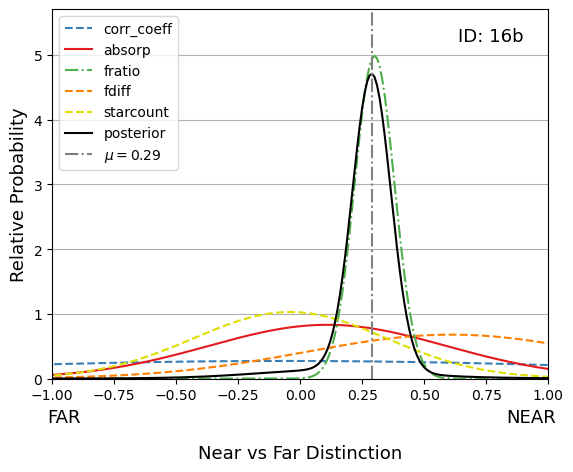

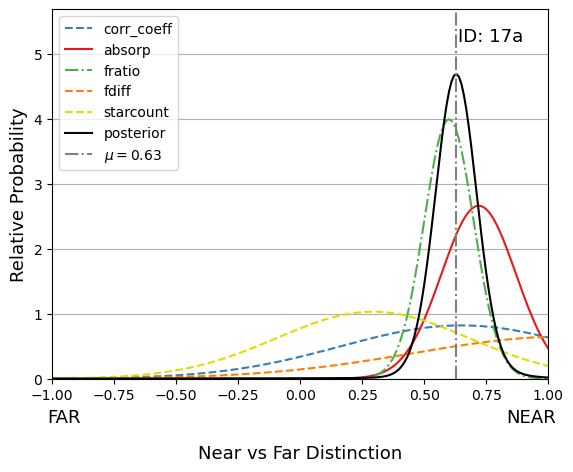

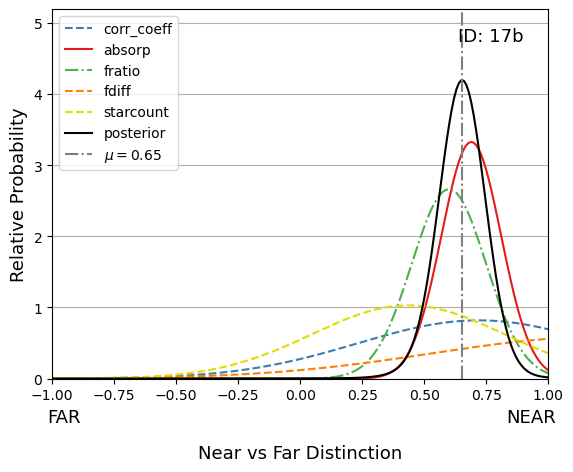

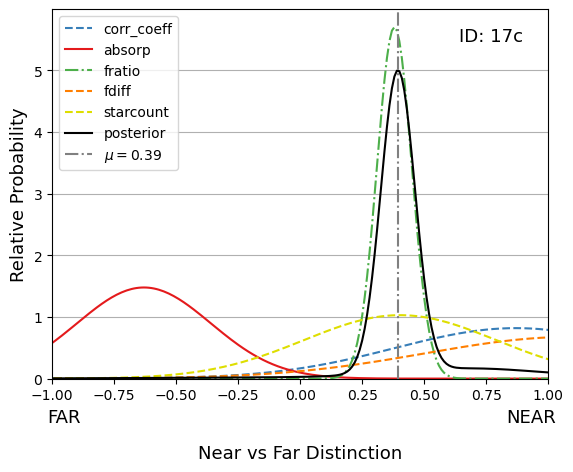

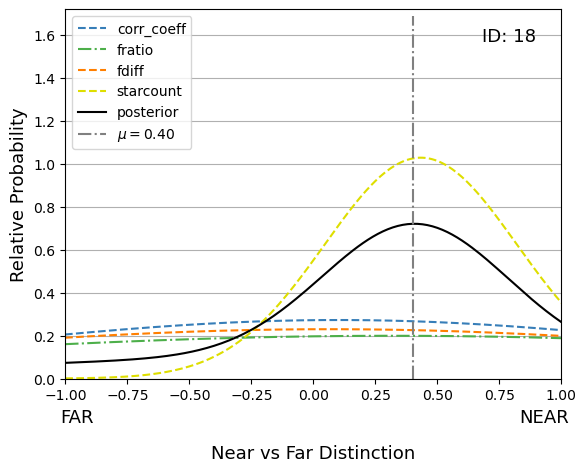

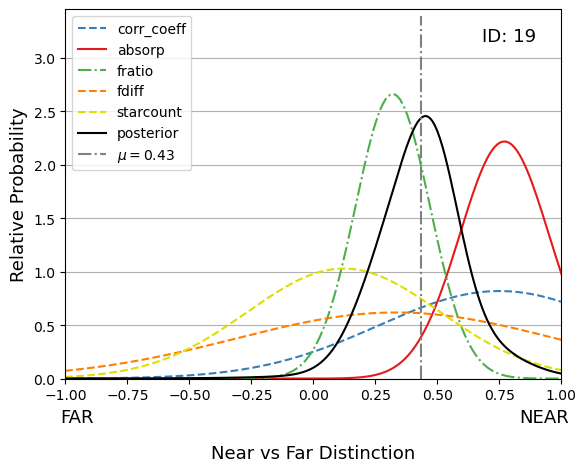

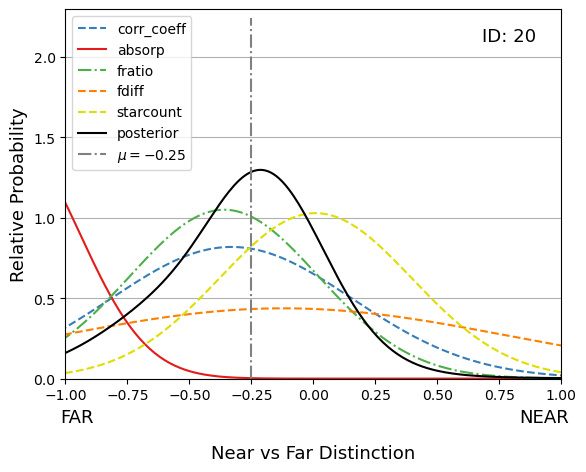

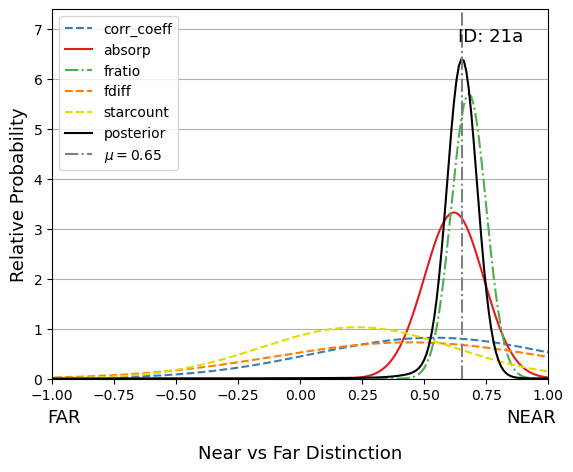

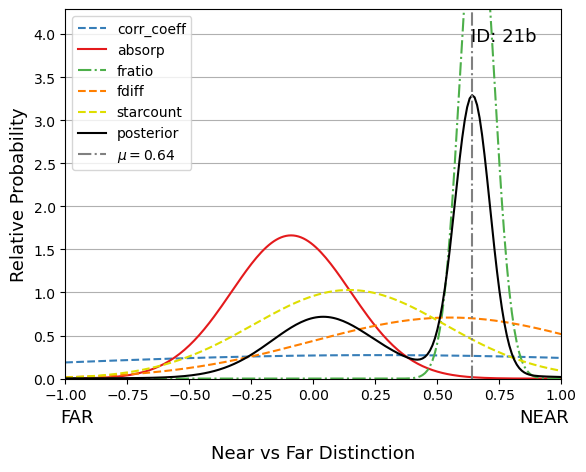

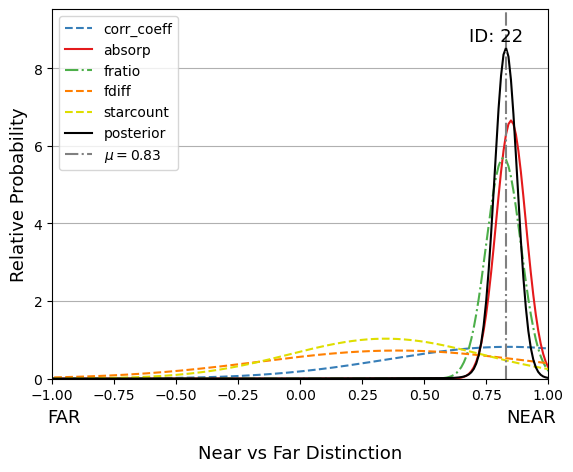

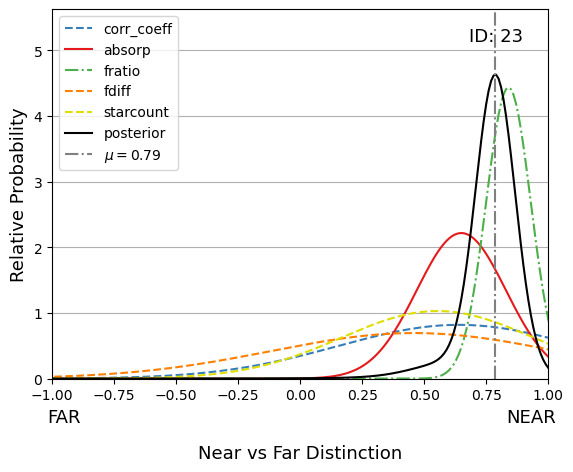

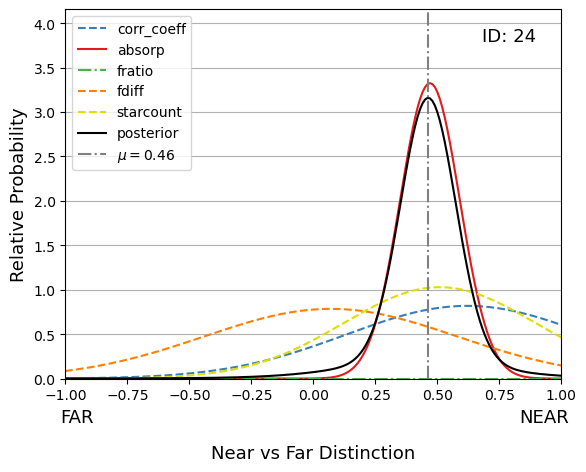

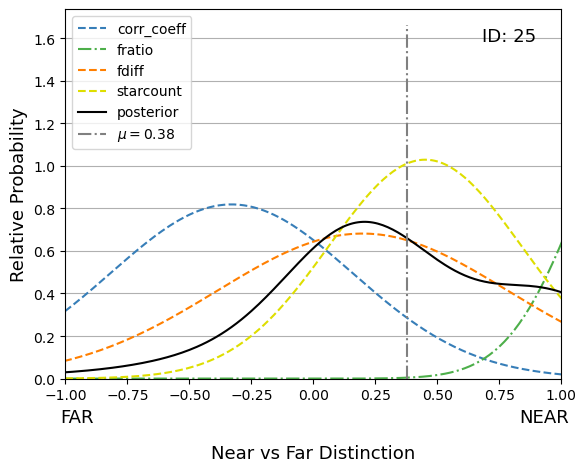

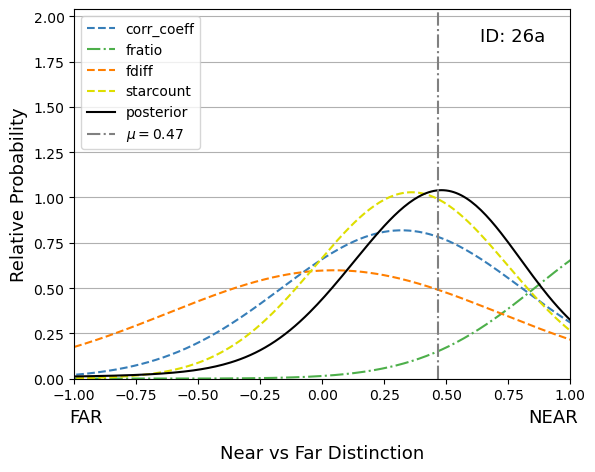

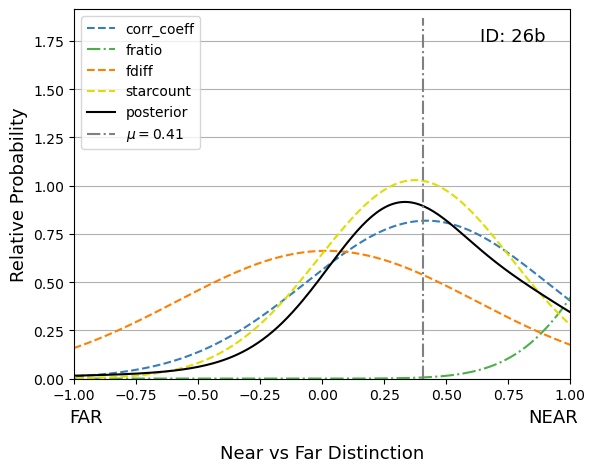

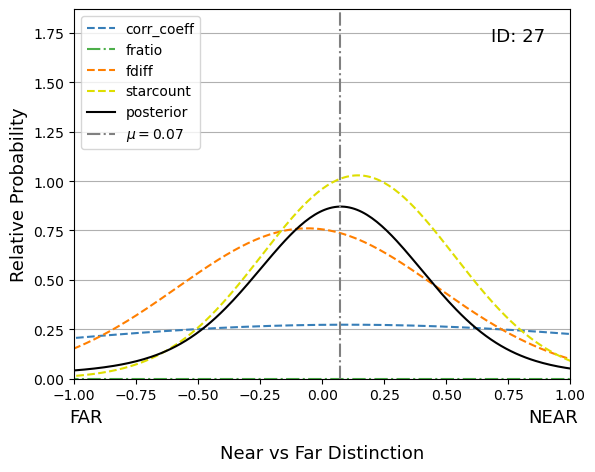

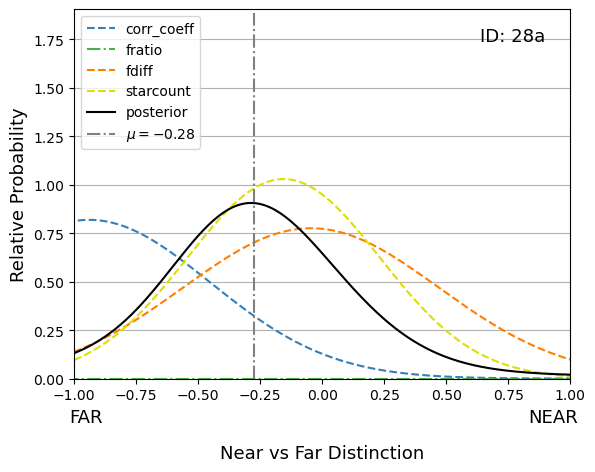

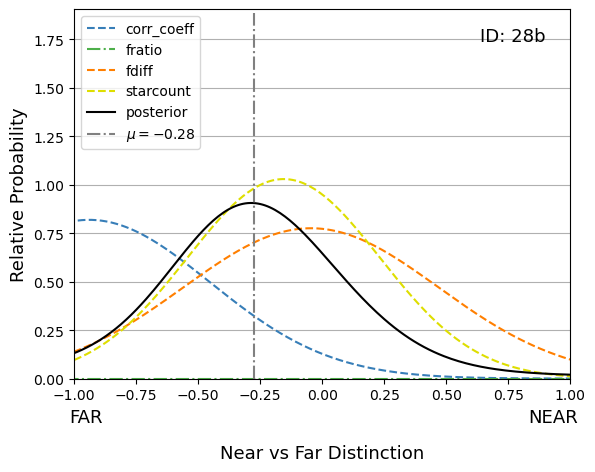

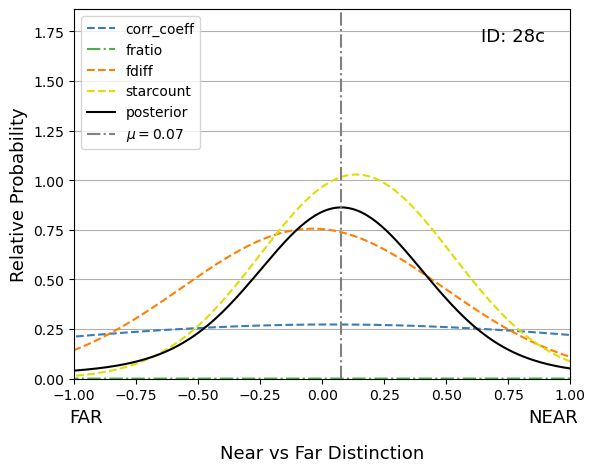

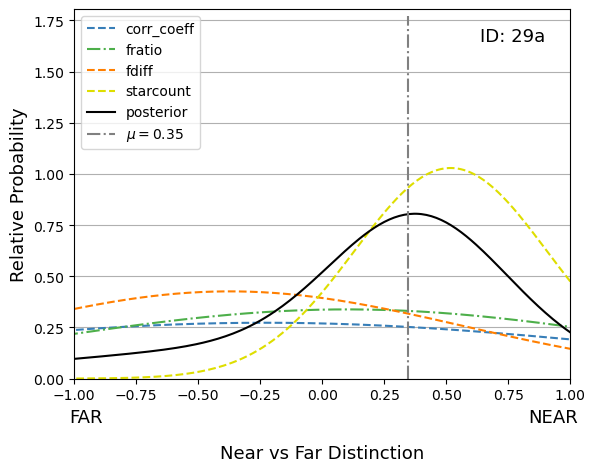

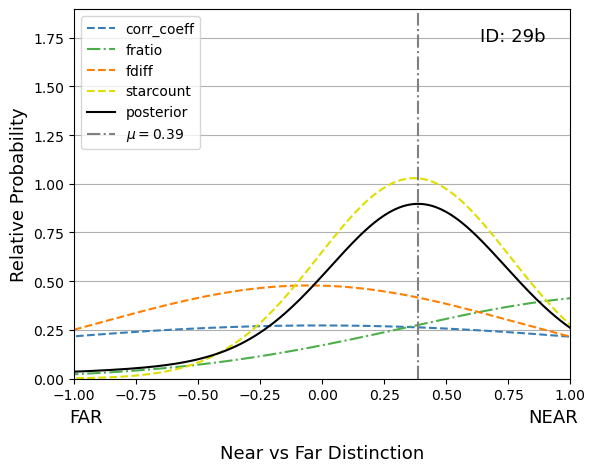

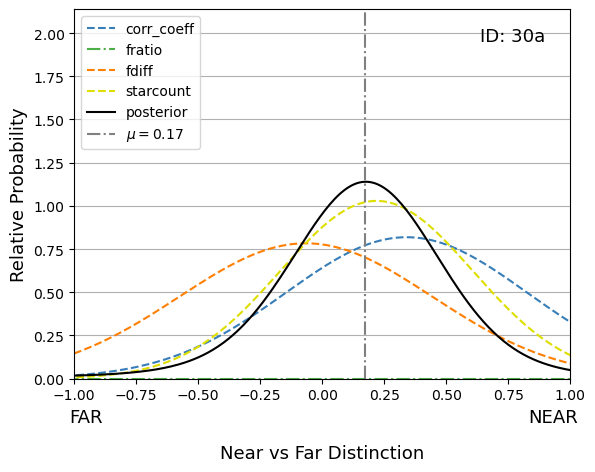

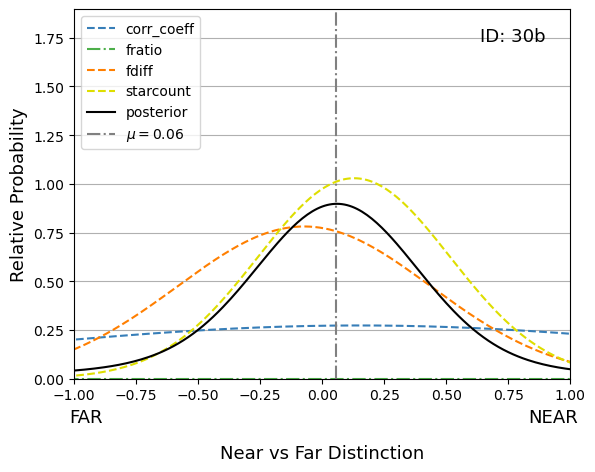

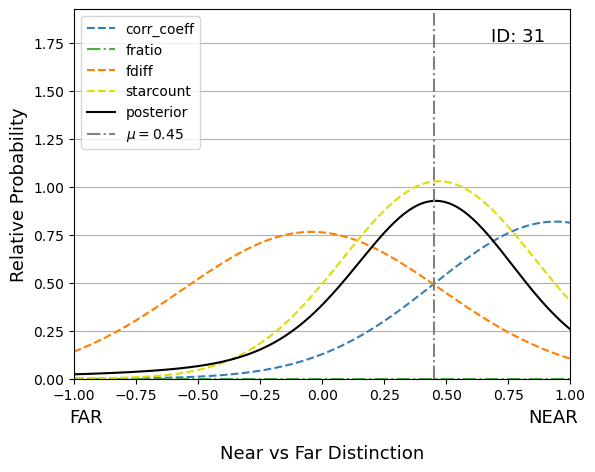

In [242]:
post_tab = Table()
A, mu, CI68, cloudid, sigma = [], [], [], [], []


#for i in ['2','16a', '17b']:

for i in cat_index:
    cat_id = np.where(cat_index == i)[0][0]
    
    #determine the PPDF from the various methods
    pdfvec=ppdf(i)


        
    
    
    #This is to do a curve-fit for the non-MC parameters (i.e. the original PPDF result)
    if (~np.isnan(pdfvec.posterior).any()) & (i != '16a') == True:
        parameters, covariance =curve_fit(gaussian, x, pdfvec.posterior, 
                                        p0 = [1, x[np.where(pdfvec.posterior==np.max(pdfvec.posterior))][0],
                                                np.std(pdfvec.posterior)])
        
        peak_val = pdfvec.posterior.max()
        peak_mu = (x[np.where(pdfvec.posterior == pdfvec.posterior.max())[0]])
        confidence_interval = stats.norm.interval(0.68, loc=parameters[1], scale=parameters[2])
        CI_sig68 = abs(confidence_interval[1] -confidence_interval[0])

        A.append(parameters[0])
        mu.append(parameters[1])
        CI68.append(CI_sig68)
        cloudid.append(i)
        sigma.append(parameters[2])
        
    else:
        A.append(np.nan)
        mu.append(np.nan)
        CI68.append(np.nan)
        sigma.append(np.nan)
        cloudid.append(i)
        
        
        
    #PLOT!!!!
    plot_pdf(i, pdfvec)
        

post_tab['cloud_id'] = cloudid
post_tab['A'] = A
post_tab['mu'] = mu
post_tab['CI68'] = CI68
post_tab['sigma'] = sigma

    
post_tab.write("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/posterior_fits.tex", overwrite=True)



In [250]:
post_tab['CI68']/2, post_tab['sigma']

(<Column name='CI68' dtype='float64' length=47>
 0.18766433465034865
  0.1727211426924901
 0.08954182215440448
  0.2310345895069318
  0.3055870258050685
 0.10004787852135097
 0.09805180791853677
 0.08979536326740023
  0.1285995625313916
 0.13373909783564936
  0.1398379165122773
 0.11136482002305595
                 ...
 0.35955282020608503
 0.41594529657469903
 0.35660885236216733
  0.3615403011396229
  0.3615403011396229
  0.3574547046746846
  0.4384892261150498
   0.399066255087273
  0.3054632658006193
  0.3525360181034868
  0.3525062117054176,
 <Column name='sigma' dtype='float64' length=47>
 0.18871018855482902
 0.17368371814300293
 0.09004083900003448
 0.23232214597287418
 0.30729006322393787
 0.10060544565088297
  0.0985982509405634
  0.0902957930984196
 0.12931624828224836
 0.13448442623229806
 0.14061723364385295
   0.111985456501798
                 ...
 0.36155660916033716
  0.4182633609702774
 0.35859623457472317
  0.3635551663311276
  0.3635551663311276
 0.35944680082473585

# Paper Figure

In [109]:
def legend_key(key):
    if key == 'corr_coeff': return 'Lipman+2025 corr coeff'
    if key == 'absorp': return 'Walker+2025 absorp'
    if key == 'fratio': return 'Lipman+2025 fratio'
    if key == 'fdiff': return 'Lipman+2025 fdiff'
    if key == 'starcount': return 'Starcount ratio'
    if key == 'xray': return 'X-ray dist'
    if key == 'nogueras': return 'Nogueras+(in prep) dist'
    if key == 'posterior': return 'Posterior'
    if key == 'MCMC posterior': return 'MC Posterior'

def plot_pdf_ax(cloud_id, pdfvar, ax):
    
    pdfvec = vars(pdfvar)
    cat_id = np.where(cat_index == cloud_id)[0][0]

    
    ###Plot the stuff 
    for i in pdfvec.items():
        ax.plot(x, i[1], label = '{}'.format(legend_key(i[0])), linestyle=plotting_linestyles(i[0]), color=plotting_color_label(i[0]) )


    ax.set_xlabel('Near vs Far Distinction', fontsize= 13, labelpad=30)
    ax.set_ylabel('Relative Probability',fontsize= 13)

    ax.grid(axis='y')
    

    #ax.set_ylim(0,1.1)
    ax.set_xlim(-1,1)
    ax.set_ylim(0, parameters[0]+1)
    ax.vlines(parameters[1], 0, parameters[0]+1, color ='grey', linestyle='-.', label = r'$\mu$'+'$= {:.2f}$'.format(parameters[1]))


    ax.text(.95, .95, 'ID: {}'.format(cat_index[cat_id]), fontsize=13, ha='right', va='top', 
            transform=ax.transAxes)

    ax.text(-0.01, -.08, 'FAR', fontsize=13, ha='left', va='top', 
            transform=ax.transAxes)
    ax.text(0.915, -.08, 'NEAR', fontsize=13, ha='left', va='top', 
            transform=ax.transAxes)

    #ax.legend(loc=2)
    

        
    return



xray 0.02 -0.03


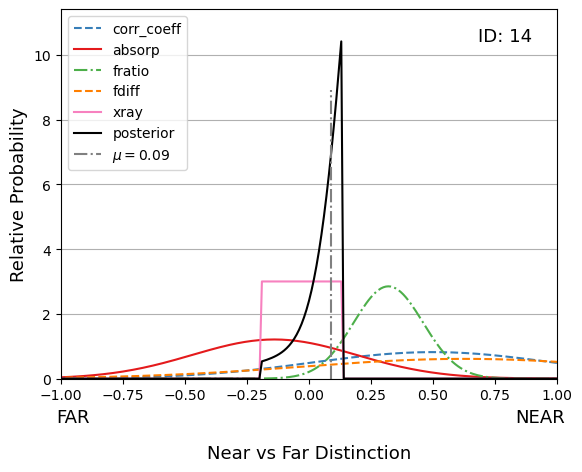

((np.float64(0.048731465087962285), np.float64(0.13231084091199002)),
 np.float64(0.08357937582402775),
 np.float64(0.023759741535852603),
 np.float64(0.12999999999989065))

In [239]:
cloudd = '14'
pdfvec=ppdf(cloudd)
plot_pdf(cloudd,pdfvec)
parameters, covariance =curve_fit(gaussian, x, pdfvec.posterior, 
                                        p0 = [1, x[np.where(pdfvec.posterior==np.max(pdfvec.posterior))][0],
                                                np.std(pdfvec.posterior)])
confidence_interval = stats.norm.interval(0.68, loc=parameters[1], scale=parameters[2])
CI_sig95 = abs(confidence_interval[1] - confidence_interval[0])
confidence_interval, CI_sig95, stats.sem(pdfvec.posterior), x[np.where(pdfvec.posterior==np.max(pdfvec.posterior))][0]

In [134]:
stats.sem(pdfvec.posterior), np.std(pdfvec.posterior)/np.sqrt(len((pdfvec.posterior)))

(np.float64(0.0042359548723967235), np.float64(0.004235425344940139))

<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:65: SyntaxWarning: invalid escape sequence '\m'
<>:81: SyntaxWarning: invalid escape sequence '\m'
<>:97: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:65: SyntaxWarning: invalid escape sequence '\m'
<>:81: SyntaxWarning: invalid escape sequence '\m'
<>:97: SyntaxWarning: invalid escape sequence '\m'
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_94355/2055239060.py:17: SyntaxWarning: invalid escape sequence '\m'
  ax[0][0].text(.05, .95, '$\mu = %.2f $ \n $A = %.2f $ \n $\mathrm{CI}_{68} = %.2f $'
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_94355/2055239060.py:33: SyntaxWarning: invalid escape sequence '\m'
  ax[0][1].text(.05, .95, '$\mu = %.2f $ \n $A 

xray 0.01 -0.03
xray 0.02 -0.03


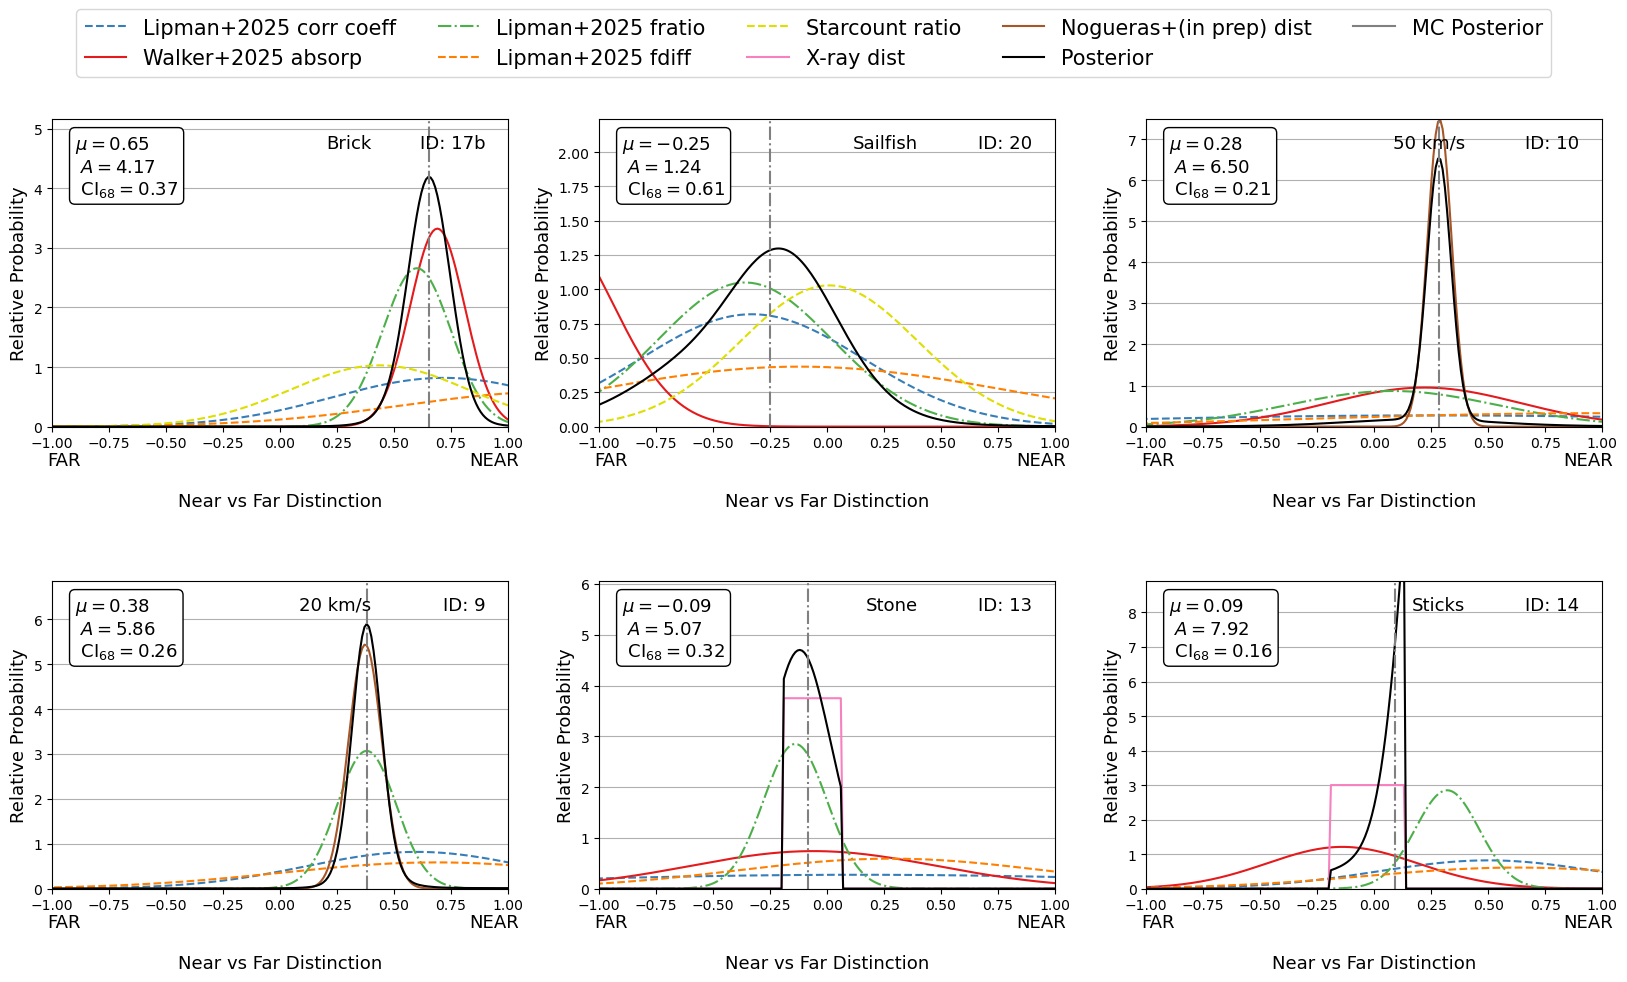

In [201]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
fig.subplots_adjust(hspace=0.5)
fig.set_facecolor('white')
fig.set_facecolor('white')


cloudd = '17b'
pdfvec=ppdf(cloudd)
parameters, covariance =curve_fit(gaussian, x, pdfvec.posterior, 
                                        p0 = [1, x[np.where(pdfvec.posterior==np.max(pdfvec.posterior))][0],
                                                np.std(pdfvec.posterior)])
confidence_interval = stats.norm.interval(0.95, loc=parameters[1], scale=parameters[2])
CI_sig95 = abs(confidence_interval[1] -confidence_interval[0])
plot_pdf_ax(cloudd,pdfvec,ax[0][0])
ax[0][0].text(.7, .95, 'Brick', fontsize=13, ha='right', va='top', 
            transform=ax[0][0].transAxes)
ax[0][0].text(.05, .95, '$\mu = %.2f $ \n $A = %.2f $ \n $\mathrm{CI}_{68} = %.2f $' 
              %(parameters[1], parameters[0], CI_sig95), 
              fontsize=13, ha='left', va='top', 
            transform=ax[0][0].transAxes,
            bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1))

cloudd = '20'
pdfvec=ppdf(cloudd)
parameters, covariance =curve_fit(gaussian, x, pdfvec.posterior, 
                                        p0 = [1, x[np.where(pdfvec.posterior==np.max(pdfvec.posterior))][0],
                                                np.std(pdfvec.posterior)])
confidence_interval = stats.norm.interval(0.68, loc=parameters[1], scale=parameters[2])
CI_sig95 = abs(confidence_interval[1] -confidence_interval[0])
plot_pdf_ax(cloudd,pdfvec,ax[0][1])
ax[0][1].text(.7, .95, 'Sailfish', fontsize=13, ha='right', va='top', 
            transform=ax[0][1].transAxes)
ax[0][1].text(.05, .95, '$\mu = %.2f $ \n $A = %.2f $ \n $\mathrm{CI}_{68} = %.2f $' 
              %(parameters[1], parameters[0], CI_sig95), 
              fontsize=13, ha='left', va='top', 
            transform=ax[0][1].transAxes,
            bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1))

cloudd = '10'
pdfvec=ppdf(cloudd)
parameters, covariance =curve_fit(gaussian, x, pdfvec.posterior, 
                                        p0 = [1, x[np.where(pdfvec.posterior==np.max(pdfvec.posterior))][0],
                                                np.std(pdfvec.posterior)])
confidence_interval = stats.norm.interval(0.95, loc=parameters[1], scale=parameters[2])
CI_sig95 = abs(confidence_interval[1] -confidence_interval[0])
plot_pdf_ax(cloudd,pdfvec,ax[0][2])
ax[0][2].text(.7, .95, '50 km/s', fontsize=13, ha='right', va='top', 
            transform=ax[0][2].transAxes)
ax[0][2].text(.05, .95, '$\mu = %.2f $ \n $A = %.2f $ \n $\mathrm{CI}_{68} = %.2f $' 
              %(parameters[1], parameters[0], CI_sig95), 
              fontsize=13, ha='left', va='top', 
            transform=ax[0][2].transAxes,
            bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1))

cloudd = '9'
pdfvec=ppdf(cloudd)
parameters, covariance =curve_fit(gaussian, x, pdfvec.posterior, 
                                        p0 = [1, x[np.where(pdfvec.posterior==np.max(pdfvec.posterior))][0],
                                                np.std(pdfvec.posterior)])
confidence_interval = stats.norm.interval(0.95, loc=parameters[1], scale=parameters[2])
CI_sig95 = abs(confidence_interval[1] -confidence_interval[0])
plot_pdf_ax(cloudd,pdfvec,ax[1][0])
ax[1][0].text(.7, .95, '20 km/s', fontsize=13, ha='right', va='top', 
            transform=ax[1][0].transAxes)
ax[1][0].text(.05, .95, '$\mu = %.2f $ \n $A = %.2f $ \n $\mathrm{CI}_{68} = %.2f $' 
              %(parameters[1], parameters[0], CI_sig95), 
              fontsize=13, ha='left', va='top', 
            transform=ax[1][0].transAxes,
            bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1))

cloudd = '13'
pdfvec=ppdf(cloudd)
parameters, covariance =curve_fit(gaussian, x, pdfvec.posterior, 
                                        p0 = [1, x[np.where(pdfvec.posterior==np.max(pdfvec.posterior))][0],
                                                np.std(pdfvec.posterior)])
confidence_interval = stats.norm.interval(0.95, loc=parameters[1], scale=parameters[2])
CI_sig95 = abs(confidence_interval[1] -confidence_interval[0])
plot_pdf_ax(cloudd,pdfvec,ax[1][1])
ax[1][1].text(.7, .95, 'Stone', fontsize=13, ha='right', va='top', 
            transform=ax[1][1].transAxes)
ax[1][1].text(.05, .95, '$\mu = %.2f $ \n $A = %.2f $ \n $\mathrm{CI}_{68} = %.2f $' 
              %(parameters[1], parameters[0], CI_sig95), 
              fontsize=13, ha='left', va='top', 
            transform=ax[1][1].transAxes,
            bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1))

cloudd = '14'
pdfvec=ppdf(cloudd)
parameters, covariance =curve_fit(gaussian, x, pdfvec.posterior, 
                                        p0 = [1, x[np.where(pdfvec.posterior==np.max(pdfvec.posterior))][0],
                                                np.std(pdfvec.posterior)])
confidence_interval = stats.norm.interval(0.95, loc=parameters[1], scale=parameters[2])
CI_sig95 = abs(confidence_interval[1] -confidence_interval[0])
plot_pdf_ax(cloudd,pdfvec,ax[1][2])
ax[1][2].text(.7, .95, 'Sticks', fontsize=13, ha='right', va='top', 
            transform=ax[1][2].transAxes)
ax[1][2].text(.05, .95, '$\mu = %.2f $ \n $A = %.2f $ \n $\mathrm{CI}_{68} = %.2f $' 
              %(parameters[1], parameters[0], CI_sig95), 
              fontsize=13, ha='left', va='top', 
            transform=ax[1][2].transAxes,
            bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1))

legendkeys = ['corr_coeff','absorp', 'fratio', 'fdiff', 'starcount', 'xray', 'nogueras', 'posterior', 'MCMC posterior']



legenditems = [mpl.lines.Line2D([],[], color=plotting_color_label(i) ,linestyle=plotting_linestyles(i), label=legend_key(i))
               for i in legendkeys]

fig.legend(handles=legenditems, ncol=5,loc="upper center" , borderaxespad=.5, fontsize= 15)

plt.savefig('./paper_items/Figs/PPDF_MCMC.pdf', bbox_inches='tight')

<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_72810/3532198645.py:12: SyntaxWarning: invalid escape sequence '\m'
  ax[0][0].text(.05, .95, '$\mu_{MCMC} = %.2f $ \n $A_{MCMC} = %.2f $ \n $\sigma_{MCMC} = %.2f $'


Text(0.05, 0.95, '$\\mu_{MCMC} = 0.14 $ \n $A_{MCMC} = 6.99 $ \n $\\sigma_{MCMC} = 0.08 $')

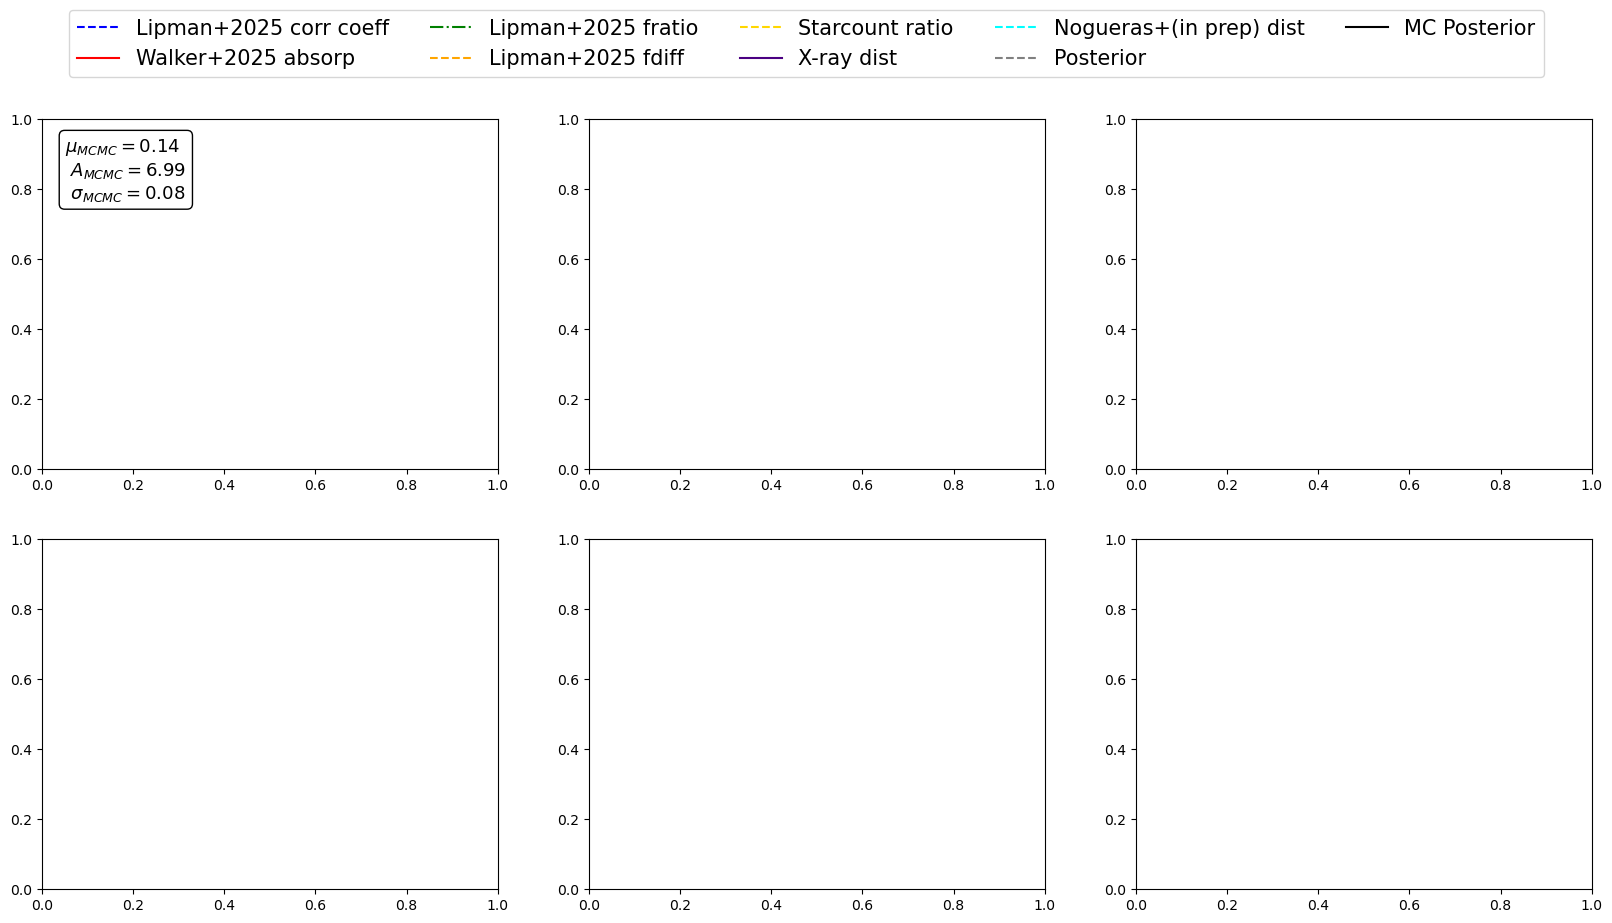

In [44]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

legendkeys = ['corr_coeff','absorp', 'fratio', 'fdiff', 'starcount', 'xray', 'nogueras', 'posterior', 'MCMC posterior']



legenditems = [mpl.lines.Line2D([],[], color=plotting_color_label(i) ,linestyle=plotting_linestyles(i), label=legend_key(i))
               for i in legendkeys]

fig.legend(handles=legenditems, ncol=5,loc="upper center" , borderaxespad=.5, fontsize= 15)

ax[0][0].text(.05, .95, '$\mu_{MCMC} = %.2f $ \n $A_{MCMC} = %.2f $ \n $\sigma_{MCMC} = %.2f $' 
              %(mcmc_post.mcmc_fit_mean[1], mcmc_post.mcmc_fit_mean[0], mcmc_post.mcmc_fit_mean[2]), 
              fontsize=13, ha='left', va='top', 
            transform=ax[0][0].transAxes,
            bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1))

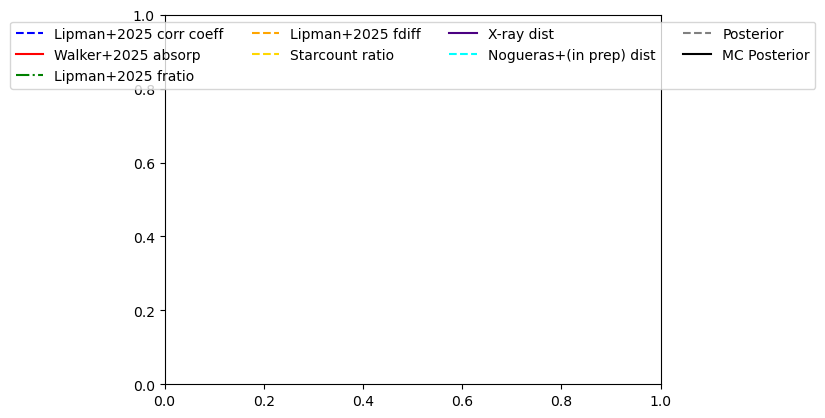

In [39]:
legenditems